In [24]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patheffects as path_effects
from shapely.geometry import Point, mapping, box
import rasterio
from rasterio.mask import mask
import matplotlib.patches as patches
from matplotlib.patches import Patch
import seaborn as sns

## Import Volcano Catalogue and Reproject Coordinates

In [25]:
volcano_data = pd.read_csv("Data_Inputs/CH_Hazard_Scoring.csv", encoding="latin1")

volcano_df = pd.DataFrame(volcano_data)

volcano_gdf = gpd.GeoDataFrame(
    volcano_df, 
    geometry=gpd.points_from_xy(volcano_df["LON_CENTRE"], volcano_df["LAT_CENTRE"]),
    crs="EPSG:4326"
)


## Assign Variables

In [26]:
recurrence = volcano_gdf ["Recurrence_Interval"]
description = volcano_gdf ["VOLCANIC_CENTRE_DESCRIPTION_NEW"]
Lahar_His = volcano_gdf ["Lahar_History"]
PDC_His = volcano_gdf ["PDC_History"]
Concentrate = volcano_gdf ["PM2.5"]
VEI = volcano_gdf ["VEI"]
Flank_Rebuilt = volcano_gdf ["Rebuilt_Flank"]
Slope_Degrees = volcano_gdf ["Max_Slope_Degrees"]
Slope_Percent = volcano_gdf ["Max_Slope_%"]
Water = volcano_gdf ["Water"]
dome = volcano_gdf ["Cone Height (m)"]
rainfall = volcano_gdf ["Average_Rainfall"]
Lava_Delta = volcano_gdf ["LavaDelta"]
Delta_Slope_Degrees = volcano_gdf ["DeltaSlope"]
Unstable_Slopes = volcano_gdf ["Unstable_Slopes"]
Buildings_3km = volcano_gdf ["Built_3km"]
geochemistry = volcano_gdf ["Bulk Geochem"]

# Defining Functions

## Recurrence Interval

In [27]:
def compute_recurrence(recurrence: int, vtype: int) -> int:
    if recurrence <= 99:
        return 20
    elif recurrence <= 1000:
        return 16
    elif recurrence <= 5000:
        return 12
    elif recurrence <= 10000:
        return 8
    elif recurrence > 10000 or vtype == 1:
        return 4
    return 0


def volcano_type(description: str) -> int:
    return 1 if description in {"Maar", "Magmatic_Volcanic_Complex", "Maar_Cone_Volcanic_Complex"} else 0

In [28]:
def recurrence_score(description, recurrence):
    funcs = [
        lambda: compute_recurrence(recurrence, description), 
        lambda: volcano_type(description)
    ]
    return sum(f() for f in funcs)

## Lahar

In [29]:
def lahar_history(Lahar_His: bool) -> int:
    return 7 if Lahar_His is True else 0


def L_water_check(Water: bool) -> int:
    return 5 if Water is True else 0

def slope_lahar(Slope_Degrees: float, Slope_Percent: float) -> int:
    return 3 if (Slope_Degrees >= 14.036 or Slope_Percent >= 25) else 0


def geochem(geochemistry, VEI):
    if pd.isna(geochemistry):
        return 0  
    geo = str(geochemistry).lower()
    keywords = {"trachyandesite", "icelandite", "trachydacite", "rhyolite", "andesite", "dacite", "trachyte"}
    if any(k in geo for k in keywords) or VEI >= 2:
        return 2
    return 0



def rain(rainfall: float) -> int:
    if rainfall >= 2500:
        return 3
    elif rainfall >= 1168:
        return 2
    return 0


def lahar_score(Lahar_His, Water, geochemistry, VEI, slope_deg, slope_pct, rainfall):
    funcs = [
        lambda: lahar_history(Lahar_His),
        lambda: L_water_check(Water),
        lambda: geochem(geochemistry, VEI),
        lambda: slope_lahar(slope_deg, slope_pct),
        lambda: rain(rainfall),
    ]
    return sum(f() for f in funcs)




## PDCs

In [30]:
def PDC_history(PDC_His: str) -> int:
    return 8 if PDC_His == "TRUE" else 0


def flank_history(Flank_Rebuilt: str) -> int:
    return 4 if Flank_Rebuilt == "TRUE" else 0


def slope_PDC(Slope_Degrees: float, Slope_Percent: float) -> int:
    return 2 if (Slope_Degrees >= 8.53 or Slope_Percent >= 15) else 0


def dome_height(dome: float) -> int:
    if dome >= 150:
        return 2
    elif dome >= 50:
        return 1
    return 0


def PDC_score(PDC_His, Flank_Rebuilt, geochemistry, VEI, slope_deg, slope_pct, dome):
    funcs = [
        lambda: PDC_history(PDC_His),
        lambda: flank_history(Flank_Rebuilt),
        lambda: geochem(geochemistry, VEI),
        lambda: slope_PDC(slope_deg, slope_pct),
        lambda: dome_height(dome),
    ]
    return sum(f() for f in funcs)

## Tephra

In [31]:

def tephra_VEI(VEI: int) -> int:
    return 2 if VEI >= 2 else 0

def pollution(Concentrate: float) -> int:
    return 1 if Concentrate > 5 else 0

def T_water_check(Water: bool) -> int:
    return 3 if Water is True else 0


def building_check(Buildings_3km: bool) -> int:
    return 4 if Buildings_3km is True else 0

def T_volcano_type(description: str) -> int:
    return 8 if description in {"Maar", "Magmatic_Volcanic_Complex", "Maar_Cone_Volcanic_Complex"} else 2

def explosive_VEI(VEI: int, vtype_score: int) -> int:

    if vtype_score == 8:
        if VEI == 2:
            return 3
        elif VEI in {3, 4}:
            return 6
        elif VEI in {5, 6}:
            return 9
        elif VEI == 7:
            return 12
        else:

            return 1 
    
    # Check if the score from T_volcano_type is 2
    if vtype_score == 2:
        return 0

    return 0 

def Tephra_score(VEI, Concentrate, Water, Buildings_3km, description):
    funcs = [
        lambda: tephra_VEI(VEI),
        lambda: pollution(Concentrate),
        lambda: T_water_check(Water),
        lambda: building_check(Buildings_3km),
        lambda: T_volcano_type(description),
        lambda: explosive_VEI(VEI, T_volcano_type(description)),
    ]
    return sum(f() for f in funcs) / 2



## Volcanic Tsunami

In [32]:
def Ts_water_check(Water: bool) -> int:
    return 12 if Water is True else 0

def fifteenshoreline(Shoreline: bool) -> int:
    return 2 if Shoreline is True else 0


def unstableslopes(Unstable_Slopes: bool) -> int:
    return 3 if Unstable_Slopes is True else 0


def tsunami_pdc(PDC_score_val: int) -> int:
    return 3 if PDC_score_val >= 10 else 0


def Tsunami_score(Water, Shoreline, Unstable_Slopes, PDC_score_val):
    funcs = [
        lambda: Ts_water_check(Water),
        lambda: fifteenshoreline(Shoreline),
        lambda: unstableslopes(Unstable_Slopes),
        lambda: tsunami_pdc(PDC_score_val),
    ]
    return sum(f() for f in funcs)


## Littoral Hazards

In [33]:

def Litt_water_check(Water: bool) -> int:
    return 6 if Water is True else 0


def delta_check(Lava_Delta: str) -> int:
    return 11 if Lava_Delta == "TRUE" else 0


def delta_slope(Delta_Slope_Degrees: float, Delta_Slope_Percent: float) -> int:
    return 1 if (Delta_Slope_Degrees >= 11.3099 or Delta_Slope_Percent >= 20) else 0


def Littoral_score(Water, Shoreline, Lava_Delta, Delta_Slope_Degrees, Delta_Slope_Percent):
    funcs = [
        lambda: Litt_water_check(Water),
        lambda: fifteenshoreline(Shoreline),
        lambda: delta_check(Lava_Delta),
        lambda: delta_slope(Delta_Slope_Degrees, Delta_Slope_Percent),
    ]
    return sum(f() for f in funcs)


## Weights

In [34]:
Recurrence_Weight = 10
Lahar_Weight = 21.70326184
PDC_Weight = 52.54473918
Tephra_Weight = 7.995938571
Tsunami_Weight = 6.853661632
Littoral_Weight = 0.9023987816

## Applying Scores into Spreadsheet

In [35]:

volcano_gdf ["Recurrence_score"] = volcano_gdf.apply(
    lambda row: recurrence_score(
        row["VEI"],
        row["Recurrence_Interval"],
    ),
    axis=1,
)
# Lahar
volcano_gdf["Lahar_Score"] = volcano_gdf.apply(
    lambda row: lahar_score(
        row["Lahar_History"],
        row["Water"],
        row["Bulk Geochem"],
        row["VEI"],
        row["Max_Slope_Degrees"],
        row["Max_Slope_%"],
        row["Average_Rainfall"],
    ),
    axis=1,
)

# PDC
volcano_gdf["PDC_Score"] = volcano_gdf.apply(
    lambda row: PDC_score(
        row["PDC_History"],
        row["Rebuilt_Flank"],
        row["Bulk Geochem"],
        row["VEI"],
        row["Max_Slope_Degrees"],
        row["Max_Slope_%"],
        row["Cone Height (m)"],
    ),
    axis=1,
)


volcano_gdf["Tephra_Score"] = volcano_gdf.apply(
    lambda row: Tephra_score(
        row["VEI"],
        row["PM2.5"],
        row["Water"],
        row["Built_3km"],
        row["VOLCANIC_CENTRE_DESCRIPTION_NEW"],
    ),
    axis=1,
)


volcano_gdf["Tsunami_Score"] = volcano_gdf.apply(
    lambda row: Tsunami_score(
        row["Water"],
        row["Shoreline_15km"],
        row["Unstable_Slopes"],
        row["PDC_Score"],
    ),
    axis=1,
)

# Littoral 
volcano_gdf["Littoral_Score"] = volcano_gdf.apply(
    lambda row: Littoral_score(
        row["Water"],
        row["Shoreline_15km"],
        0, 
        row["DeltaSlope"],
        0,  
    ),
    axis=1,
)



In [36]:
volcano_gdf["Total_Hazard_Score"] = ((
    (volcano_gdf ["Recurrence_score"] * Recurrence_Weight)
    + (volcano_gdf["Lahar_Score"] * Lahar_Weight)
    + (volcano_gdf["PDC_Score"] * PDC_Weight)
    + (volcano_gdf["Tephra_Score"] * Tephra_Weight)
    + (volcano_gdf["Tsunami_Score"] * Tsunami_Weight)
    + (volcano_gdf["Littoral_Score"] * Littoral_Weight)
)/100)

## Create copy of dataframe and export

In [37]:

volcano_gdf_csv = volcano_gdf.copy()


volcano_gdf_csv = volcano_gdf_csv.drop(columns='geometry')


volcano_gdf_csv.to_csv('DataMap_Outputs/Hazard_Scoring_OutputCH.csv', index=False)

# Mapping

In [38]:
LGAS= gpd.read_file("NVP_Locations/VIC_SA_LGAs_NVP.gpkg")
colac_lin = gpd.read_file("NVP_Locations/colac_lineament.gpkg")
shapefile = gpd.read_file("Aus_Shapefile/STE_2021_AUST_GDA2020.shp")
CH = gpd.read_file("NVP_Locations/subProvincesAndRegions.gdb", layer="CentralHighlands")
CH = CH.to_crs(LGAS.crs)

In [39]:
burrumbeet = volcano_gdf[volcano_gdf["Volcanic Centre Name"] == "Lake_Burrumbeet_Callender_Bay"]
other_points  = volcano_gdf[volcano_gdf["Volcanic Centre Name"] != "Lake_Burrumbeet_Callender_Bay"]

In [40]:
CH_proxy = Patch(facecolor='#ef78ff', edgecolor='#b102c9', label='Central Highlands Subprovince')
handles = [CH_proxy]

In [41]:
norm = mpl.colors.Normalize(
    vmin=volcano_gdf["Total_Hazard_Score"].min(),
    vmax=volcano_gdf["Total_Hazard_Score"].max()
)
cmap = plt.colormaps.get_cmap("plasma")

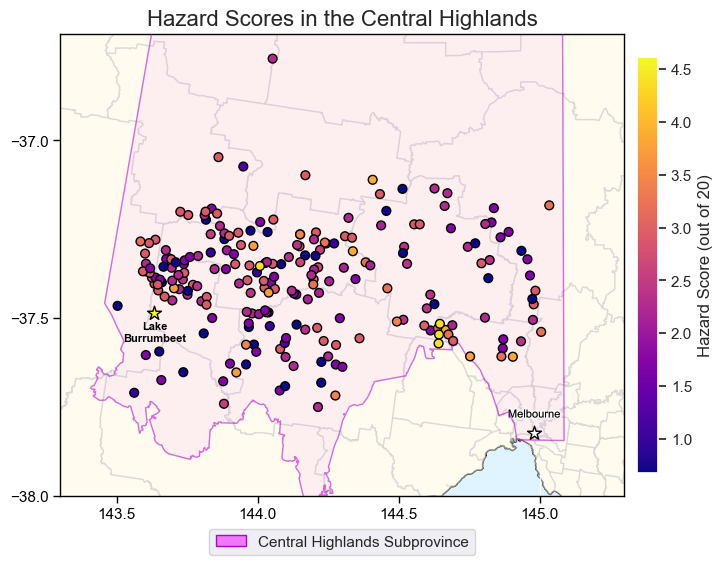

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))
LGAS.plot(ax=ax,color='#fffbe0', edgecolor='#CCCCCC', zorder=1, alpha=0.5)
shapefile.plot(ax=ax, color='white',edgecolor='black', zorder=0)
CH.plot(ax=ax, color='#ef78ff', edgecolor='#b102c9', alpha=0.1, zorder=2)
CH.plot(ax=ax, facecolor='none', edgecolor='#b102c9', zorder=4, alpha=0.5)

ax.legend(handles=handles, frameon=True,loc='center',bbox_to_anchor=(0.5,-0.1), ncol=3)

other_points.plot(
    ax=ax,
    column="Total_Hazard_Score",
    cmap=cmap,
    norm=norm,
    markersize=40,
    edgecolor="black",
    zorder=5,
    legend=True,
    legend_kwds={
        "label": "Hazard Score (out of 20)",
        "shrink": 0.9,
        "fraction": 0.05,
        "pad": 0.02           
    }
)

# Plot the special volcano as a star
burrumbeet.plot(
    ax=ax,
    column="Total_Hazard_Score",
    cmap=cmap,
    norm=norm,
    markersize=110,  
    edgecolor="black",   
    marker="*",            
    zorder=5
)

ax.scatter(144.97806, -37.8240, facecolor='white', edgecolor='black',marker='*', zorder=3, s=110)


Melbourne = ax.annotate(
    'Melbourne',
    xy=(144.97806, -37.8240),
    xytext=(144.98, -37.78),
    fontsize=8,
    color='black',
    ha="center"
)
Melbourne.set_path_effects([
    path_effects.Stroke(linewidth=3, foreground=(1, 1, 1, 0.6)),
    path_effects.Normal()
    ])

Burrumbeet = ax.annotate(
    'Lake\nBurrumbeet',
    xy=(143.6332, -37.4848),
    xytext=(143.6332, -37.565),
    fontsize=8,
    fontweight='bold',
    color='black',
    ha="center"
)
Melbourne.set_path_effects([
    path_effects.Stroke(linewidth=3, foreground=(1, 1, 1, 0.6)),
    path_effects.Normal()
    ])

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor("black")


ax.set_facecolor('#e0f4ff')
ax.set_xlim(143.3, 145.3)
ax.set_ylim(-38,-36.7)
ax.set_xticks([143.5, 144, 144.5, 145])
ax.set_yticks([-37, -37.5, -38])
ax.tick_params(axis="both", which="both", direction="out", length=5, width=1, colors="black")
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_title("Hazard Scores in the Central Highlands", fontsize=16)

ax.set_axis_on()

plt.savefig("DataMap_Outputs/hazardmapch.png", dpi=600)
plt.show()

In [43]:
hazard_scores=volcano_gdf["Total_Hazard_Score"]

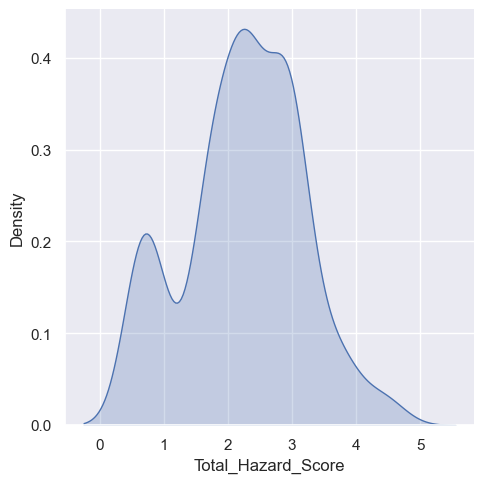

In [44]:
sns.set_theme(style="darkgrid")
ax = sns.displot(data=hazard_scores, kind="kde", fill=True)
plt.savefig("DataMap_Outputs/hazarddistributionch.png", dpi=600)